<a href="https://colab.research.google.com/github/JoshStrong/CNN-tuning/blob/master/CNN_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Julia on Colaboratory ##

[Colaboratory](https://colab.research.google.com) does not provide native support for the [Julia programming language](https://julialang.org). However, since Colaboratory gives you root access to the machine that runs your notebook (the *“runtime”* in Colaboratory terminology), we can install Julia support by uploading a specially crafted Julia notebook  – *this* notebook. We then install Julia and [IJulia](https://github.com/JuliaLang/IJulia.jl) ([Jupyter](https://jupyter.org)/Colaboratory notebook support) and reload the notebook so that Colaboratory detects and initiates what we installed.

In brief:

1. **Run the cell below**
2. **Reload the page**
3. **Edit the notebook name and start hacking Julia code below**

**If your runtime resets**, either manually or if left idle for some time, **repeat steps 1 and 2**.

### Acknowledgements ###

This hack by Pontus Stenetorp is an adaptation of [James Bradbury’s original Colaboratory Julia hack](https://discourse.julialang.org/t/julia-on-google-colab-free-gpu-accelerated-shareable-notebooks/15319/27), that broke some time in September 2019 as Colaboratory increased their level of notebook runtime isolation. There also appears to be CUDA compilation support installed by default for each notebook runtime type in October 2019, which shaves off a good 15 minutes or so from the original hack’s installation time.

In [ ]:
%%shell
if ! command -v julia 2>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.0/julia-1.0.5-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'

In [ ]:
using Pkg

Pkg.add(Pkg.PackageSpec(;name="CuArrays", version=v"1.3.0"))
Pkg.add(Pkg.PackageSpec(;name="Flux", version=v"0.9.0"))

pkg"add MLDatasets"
pkg"add ImageMagick"
pkg"add Images"
pkg"add Plots"
pkg"precompile"

using CuArrays
using ImageMagick
using Images
using Flux
using MLDatasets
using Plots

using LinearAlgebra
using Random

using Base.Iterators: partition
using Flux: @epochs, crossentropy, onehotbatch, onecold
import Statistics
using Statistics

# Convolutional Neural Network Tuning  #

A standard procedure in machine learning research to understand both your data and model is to
explore variants that you hypothesise might work better based on experimental observations.

This project:


*   Implements a multi-class, convolutional neural network with cross-entropy loss for the
Fashion-MNIST-1 data.
*   Iteratively makes modifications to the model based on how changes affect the validation
loss





## Data ##

In [ ]:
# Download the dataset.
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o /tmp/train-images-idx3-ubyte.gz`)
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o /tmp/train-labels-idx1-ubyte.gz`)
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o /tmp/t10k-images-idx3-ubyte.gz`)
run(`curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o /tmp/t10k-labels-idx1-ubyte.gz`)

nothing

In [ ]:
# Then load it into RAM.
vanillaxs, vanillays = MNIST.traindata(dir="/tmp")
# There is no proper train/validation/test split provided, thus we create our own.
fmtrainxs            = vanillaxs[:, :, 1:50_000]
fmtrainys            = vanillays[1:50_000]
fmvalidxs            = vanillaxs[:, :, 50_001:end]
fmvalidys            = vanillays[50_001:end]
fmvanillaxs          = vanillaxs[1:0]
fmvanillays          = vanillays[1:0]
fmtestxs, fmtestys   = MNIST.testdata(dir="/tmp")

nothing

In [ ]:
function filter(xs, ys, lbls)
    idxs    = [i for (i, y) in enumerate(ys) if y in lbls]
    xsprime = Array{eltype(xs)}(undef, size(xs)[1:2]..., length(idxs))
    for (i, j) in enumerate(idxs)
        xsprime[:, :, i] = xs[:, :, j]
    end
    ymap    = Dict(y => yprime for (yprime, y) in enumerate(lbls))
    ysprime = [ymap[y] for y in ys[idxs]]
    xsprime, ysprime
end

fm1lbls                = [0, 1, 4, 5, 8]
fm1trainxs, fm1trainys = filter(fmtrainxs, fmtrainys, fm1lbls)
fm1validxs, fm1validys = filter(fmvalidxs, fmvalidys, fm1lbls)
fm1testxs, fm1testys   = filter(fmtestxs, fmtestys, fm1lbls)

nothing

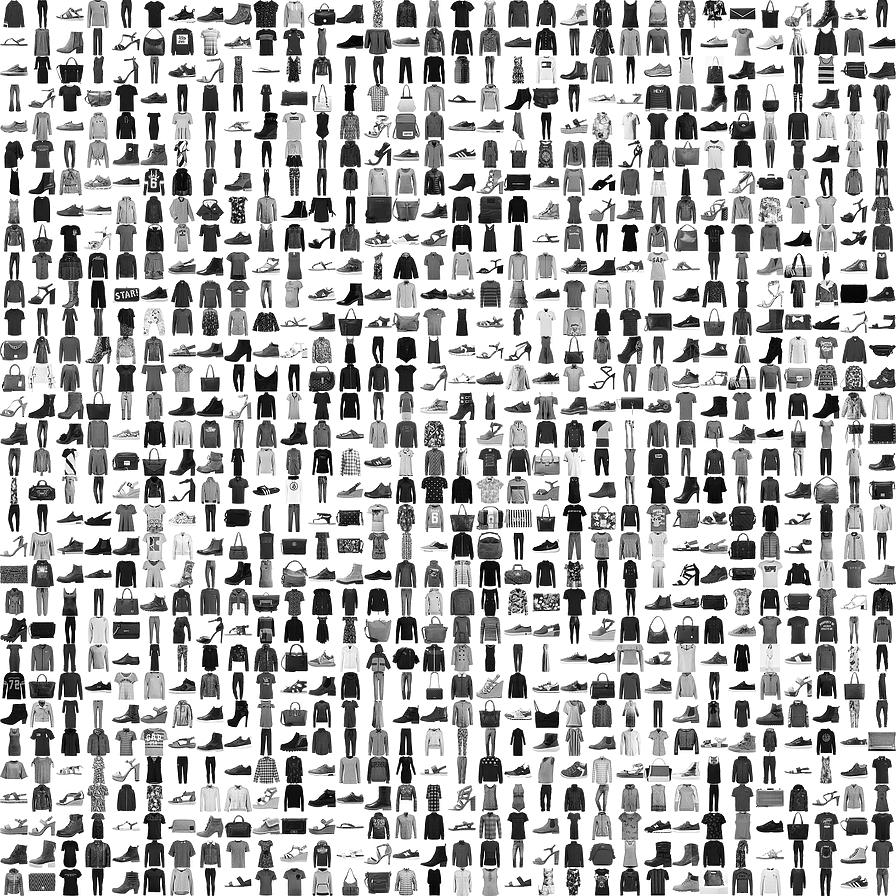

In [ ]:
vcat([hcat([MNIST.convert2image(fmtrainxs[:, :, rand(1:end)]) for _ in 1:32]...) for _ in 1:32]...)


## 1: Implement a multi-class CNN. ##

*Implement a multi-class, convolutional neural network with cross-entropy loss for the
Fashion-MNIST-1 data, then fill in information regarding it into a table akin to Table 1.*

In [ ]:
function minibatch(xs, ys, idxs)
    xsbatch = Array{Float32}(undef, size(xs[:,:,1])..., 1, length(idxs))
    for i in 1:length(idxs)
        xsbatch[:, :, :, i] = Float32.(xs[:,:,idxs[i]])
    end
    ysbatch = onehotbatch(ys[idxs], 0:9)
    xsbatch, ysbatch
end

batchsz        = 128
trainbatchidxs = partition(1:size(fm1trainxs)[3], batchsz)
# Note how we send each batch to the GPU here, not the vector of batches.
trainset       = [minibatch(fm1trainxs, fm1trainys, i) |> gpu for i in trainbatchidxs]
validset       = minibatch(fm1validxs, fm1validys, 1:size(fm1validxs)[3]) |> gpu
testset        = minibatch(fm1testxs, fm1testys, 1:size(fm1testxs)[3]) |> gpu

nothing

In [ ]:
model = Chain(
        # 28x28 input, with 3x3 filters and padding.
        Conv((3, 3), 1=>16, pad=(1, 1), relu),
        MaxPool((2, 2)),
        # 14x14 input, with 3x3 filters and padding.
        Conv((3, 3), 16=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),
        # 7x7 input, with 3x3 filters and padding.
        Conv((3, 3), 32=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(288, 10),
        softmax,
    ) |> gpu

loss(x, y)     = crossentropy(model(x), y)
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

optimiser      = ADAM(0.001)

nothing

┌ Info: Building the CUDAnative run-time library for your sm_37 device, this might take a while...
└ @ CUDAnative /root/.julia/packages/CUDAnative/Lr0yj/src/compiler/rtlib.jl:173
┌ Warning: `Target(triple::String)` is deprecated, use `Target(; triple=triple)` instead.
│   caller = machine(::VersionNumber, ::String) at mcgen.jl:6
└ @ CUDAnative /root/.julia/packages/CUDAnative/Lr0yj/src/compiler/mcgen.jl:6


In [ ]:
train_loss = []
valid_loss = []

train_acc  = []
valid_acc  = []

bestParams  = undef
bestValLoss = 100

epochs = 50

println("Base model:")
println("Epoch\tTraining loss\tValid loss\tTraining acc\tValid acc")
println("-----------------------------------------------------------------")
for epoch in 1:epochs
    Random.seed!(50)
    Flux.train!(loss, params(model), trainset, optimiser)
    # Note the `data`, as it immediately releases memory from the computation graph.
    valLoss = loss(validset...).data
    if (epoch%5 == 0 || epoch == 1)
      println("$(epoch)\t$(loss(trainset[1]...).data)\t$(valLoss)\t$(round(accuracy(trainset[1]...),digits=5))\t\t$(round(accuracy(validset...),digits=5))")
    end
    append!(train_loss, loss(trainset[1]...).data)
    append!(valid_loss, valLoss)

    # Store best model parameters for early stopping
    if valLoss < bestValLoss
      bestParams = deepcopy(Tracker.data.(Flux.params(model)))
      bestValLoss = valLoss
    end

    flush(stdout)
end

Base model:
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------


┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /root/.julia/packages/GPUArrays/tIMl5/src/indexing.jl:16


1	0.11030253	0.1308168	0.96094		0.959
5	0.059956852	0.06806232	0.98438		0.97871
10	0.061161973	0.054578215	0.98438		0.98348
15	0.043792978	0.051088102	0.98438		0.98567
20	0.019515336	0.0516646	0.99219		0.98627
25	0.012531286	0.060022485	0.99219		0.98507
30	0.0069788606	0.05997093	1.0		0.98527
35	0.00086239114	0.060051125	1.0		0.98587
40	0.0007928512	0.068996936	1.0		0.98468
45	0.00025383162	0.071801186	1.0		0.98527
50	0.00012751711	0.07543233	1.0		0.98587


In [ ]:
bestModel = deepcopy(model)
Flux.loadparams!(bestModel, bestParams)

Below is a plot of the validation & training loss for each epoch of training for the above model. After epoch ≅22, the validation loss begins to steadily increase again whilst the training loss continues to decrease - which could be a sign of the model overfitting to the training data from that point onwards. The model reaches a validation low of 0.0534 at which we obtain a validation accuracy of 98.57%.


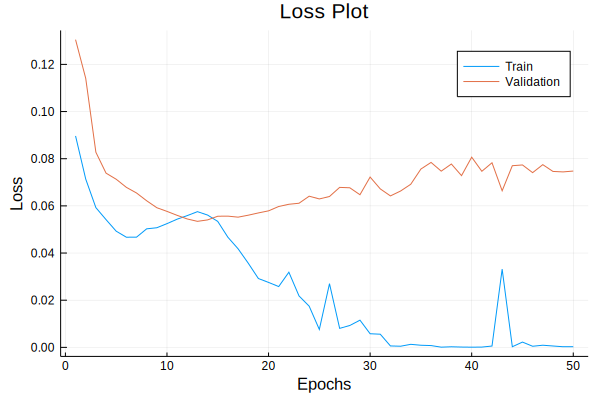

In [ ]:
plot([train_loss, valid_loss], xlabel="Epochs", ylabel="Loss", title="Loss Plot", label=["Train" "Validation"])

In [ ]:
best_accuracy(x, y) = mean(onecold(bestModel(x)) .== onecold(y))
best_loss(x, y)     = crossentropy(bestModel(x), y);

In [ ]:
println("Base model:")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(best_loss(validset...).data)")
println("Training loss at best validation epoch:\t\t $(best_loss(trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(best_loss(testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(best_accuracy(validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(best_accuracy(trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(best_accuracy(testset...)*100,digits=2))%")

Base model:
-------------------------------------------------------------
Lowest validation loss:				 0.05344309
Training loss at best validation epoch:		 0.057551775
Testing loss at best valdation epoch:		 0.048765443

Accuracy at best validation epoch:		 98.57%
Training accuracy at best validation epoch:	 98.44%
Testing accuracy at best validation epoch:	 98.4%


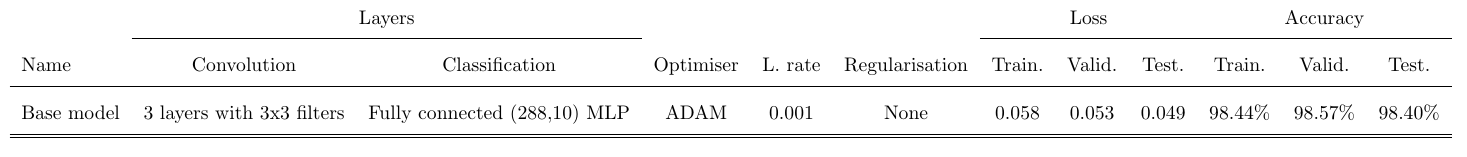

## 2: Iteratively making modifications to the model. ##


### Model 2 & 3

First, we'll investigate the effect of changing the convolutional layers of the base model on the validation loss & accuracy. We'll consider 2 variants of the model:

1.   Using 2 convolution & pooling layers
2.   Using 4 convolution & pooling layers



In [ ]:
model_2 = Chain(
        Conv((3, 3), 1=>16, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 16=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        x -> reshape(x, :, size(x, 4)),
        Dense(1568, 10),
        softmax,
    ) |> gpu

loss_2(x, y)     = crossentropy(model_2(x), y)
accuracy_2(x, y) = mean(onecold(model_2(x)) .== onecold(y))

optimiser      = ADAM(0.001)

nothing

In [ ]:
model_3 = Chain(
        Conv((3, 3), 1=>16, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 16=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32=>32, pad=(1,1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(32, 10),
        softmax,
    ) |> gpu

loss_3(x, y)     = crossentropy(model_3(x), y)
accuracy_3(x, y) = mean(onecold(model_3(x)) .== onecold(y))

optimiser      = ADAM(0.001)

nothing

In [ ]:
# Defining function for training models
function train(train_loss, valid_loss, loss, model, accuracy, epochs=50)
  Random.seed!(50)
  bestValLoss = 100
  best_model = deepcopy(model)
  println("Epoch\tTraining loss\tValid loss\tTraining acc\tValid acc")
  println("-----------------------------------------------------------------")
  for epoch in 1:epochs
      Flux.train!(loss, params(model), trainset, optimiser)
      valLoss = loss(validset...).data
      if (epoch%5 == 0 || epoch == 1)
        println("$(epoch)\t$(loss(trainset[1]...).data)\t$(valLoss)\t$(round(accuracy(trainset[1]...),digits=5))\t\t$(round(accuracy(validset...),digits=5))")
      end
      append!(train_loss, loss(trainset[1]...).data)
      append!(valid_loss, valLoss)

      # Store best model parameters for early stopping
      if valLoss < bestValLoss
        best_weights = deepcopy(Tracker.data.(Flux.params(model)))
        Flux.loadparams!(best_model, best_weights)
        bestValLoss = valLoss
      end
  end
  return best_model
end;

In [ ]:
train_loss_m2 = []
train_loss_m3 = []
valid_loss_m2 = []
valid_loss_m3 = []

println("Model 2: Two convolutional & pooling layers")
best_model_2 = train(train_loss_m2, valid_loss_m2, loss_2, model_2, accuracy_2)

println("")
println("Model 3: Four convolutional & pooling layers")
best_model_3 = train(train_loss_m3, valid_loss_m3, loss_3, model_3, accuracy_3)

nothing

Model 2: Two convolutional & pooling layers
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.10617359	0.10270025	0.96875		0.97134
5	0.054555062	0.06249231	0.98438		0.98209
10	0.043233138	0.04965476	0.98438		0.98587
15	0.027597954	0.04499967	0.98438		0.98786
20	0.017054154	0.044184335	0.98438		0.98945
25	0.010424779	0.048820272	1.0		0.98965
30	0.0065265493	0.05517374	1.0		0.98846
35	0.007769453	0.059139915	1.0		0.98925
40	0.0004293758	0.054305907	1.0		0.98826
45	0.00030547433	0.06293779	1.0		0.98706
50	0.00015267455	0.064076945	1.0		0.98766

Model 3: Four convolutional & pooling layers
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.094377436	0.10761629	0.96875		0.96517
5	0.029412452	0.07890327	0.99219		0.97592
10	0.0427376	0.05736613	0.99219		0.98269
15	0.019530589	0.062393375	0.99219		0.98308
20	0.007872062	0.076837875	0.99219		0.98269


In [ ]:
accuracy(m, x, y) = mean(onecold(m(x)) .== onecold(y))
loss(m, x, y)     = crossentropy(m(x), y)

println("Model 2: Two convolutional & pooling layers")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_2,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_2,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_2,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_2,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_2,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_2,testset...)*100,digits=2))%")


println("")
println("Model 3: Four convolutional & pooling layers")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_3,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_3,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_3,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_3,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_3,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_3,testset...)*100,digits=2))%")

Model 2: Two convolutional & pooling layers
-------------------------------------------------------------
Lowest validation loss:				 0.043846726
Training loss at best validation epoch:		 0.020635203
Testing loss at best valdation epoch:		 0.03871011

Accuracy at best validation epoch:		 98.89%
Training accuracy at best validation epoch:	 98.44%
Testing accuracy at best validation epoch:	 98.86%

Model 3: Four convolutional & pooling layers
-------------------------------------------------------------
Lowest validation loss:				 0.054962188
Training loss at best validation epoch:		 0.040898714
Testing loss at best valdation epoch:		 0.050103534

Accuracy at best validation epoch:		 98.43%
Training accuracy at best validation epoch:	 99.22%
Testing accuracy at best validation epoch:	 98.4%


Below is a plot of validation & training loss of all 3 models considered to this point. We can see that the validation loss for model 2 is lowest out of the 3 models, therefore we will continue with model alterations on this model.

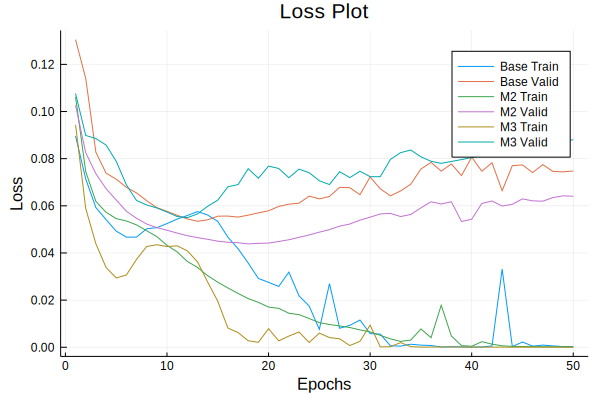

In [ ]:
plt_1 = plot([train_loss, valid_loss, train_loss_m2, valid_loss_m2, train_loss_m3, valid_loss_m3], 
              xlabel="Epochs", 
              ylabel="Loss", 
              title="Loss Plot", 
              label=["Base Train" "Base Valid" "M2 Train" "M2 Valid" "M3 Train" "M3 Valid"])

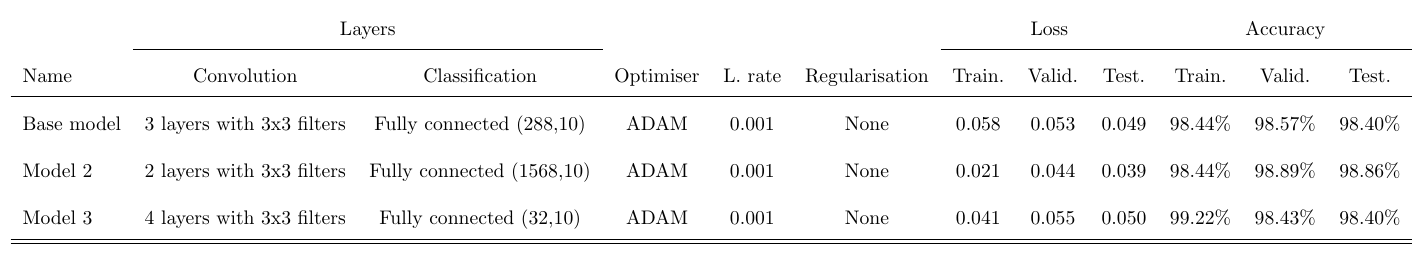

### Model 4 & 5

Next, we'll consider altering the number of feature maps in our CNN model. We'll consider an additional 2 model variants of the 2 layer CNN:


1.   1 input to 8 outputs in the first layer, and 8 inputs to 16 outputs of the second layer
2.   1 input to 32 outputs in the first layer, and 32 inputs to 64 outputs of the second layer.




In [ ]:
model_4 = Chain(
        Conv((3, 3), 1=>8, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 8=>16, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(784, 10),
        softmax,
    ) |> gpu

accuracy_4(x, y) = mean(onecold(model_4(x)) .== onecold(y))
loss_4(x, y)     = crossentropy(model_4(x), y)
optimiser      = ADAM(0.001)

nothing

In [ ]:
model_5 = Chain(
        Conv((3, 3), 1=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(3136, 10),
        softmax,
    ) |> gpu

accuracy_5(x, y) = mean(onecold(model_5(x)) .== onecold(y))
loss_5(x, y)     = crossentropy(model_5(x), y)
optimiser      = ADAM(0.001)

nothing

In [ ]:
train_loss_m4 = []
train_loss_m5 = []
valid_loss_m4 = []
valid_loss_m5 = []

println("Model 4: (1,8) => (8,16)")
best_model_4 = train(train_loss_m4, valid_loss_m4, loss_4, model_4, accuracy_4)

println("")
println("Model 5: (1,32) => (32,64)")
best_model_5 = train(train_loss_m5, valid_loss_m5, loss_5, model_5, accuracy_5);

Model 4: (1,8) => (8,16)
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.1312676	0.11863178	0.96094		0.96557
5	0.08839972	0.06416111	0.98438		0.98229
10	0.073416546	0.05457598	0.98438		0.98368
15	0.056935724	0.051518712	0.98438		0.98488
20	0.035613667	0.050248798	0.98438		0.98527
25	0.01818247	0.050349575	0.98438		0.98587
30	0.012346107	0.0522737	0.99219		0.98687
35	0.010742319	0.055962905	0.99219		0.98726
40	0.009441369	0.060328007	1.0		0.98706
45	0.007744267	0.06563731	1.0		0.98667
50	0.006163766	0.06913685	1.0		0.98687

Model 5: (1,32) => (32,64)
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.114672735	0.09897709	0.96875		0.97214
5	0.047928292	0.04864956	0.98438		0.98587
10	0.011549526	0.043354213	0.99219		0.98886
15	0.0026141421	0.046383776	1.0		0.98945
20	0.005099287	0.044447713	1.0		0.98985
25	0.0038378488	0.0521389	1.0		0.98965


In [ ]:
println("Model 4: Model 4: (1,8) => (8,16)")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_4,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_4,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_4,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_4,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_4,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_4,testset...)*100,digits=2))%")


println("")
println("Model 5: (1,32) => (32,64)")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_5,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_5,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_5,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_5,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_5,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_5,testset...)*100,digits=2))%")

Model 4: Model 4: (1,8) => (8,16)
-------------------------------------------------------------
Lowest validation loss:				 0.050003212
Training loss at best validation epoch:		 0.027435787
Testing loss at best valdation epoch:		 0.042003587

Accuracy at best validation epoch:		 98.59%
Training accuracy at best validation epoch:	 98.44%
Testing accuracy at best validation epoch:	 98.76%

Model 5: (1,32) => (32,64)
-------------------------------------------------------------
Lowest validation loss:				 0.043072212
Training loss at best validation epoch:		 0.0083492035
Testing loss at best valdation epoch:		 0.04105474

Accuracy at best validation epoch:		 98.89%
Training accuracy at best validation epoch:	 100.0%
Testing accuracy at best validation epoch:	 98.84%


Below is a plot of the loss and accuracy of model 4 & model 5 compared with the running best model 2. We've found a new validation loss low of 0.0431 from model 5 - a small but significant improvement on the loss low of 0.044 obtained by model 2.

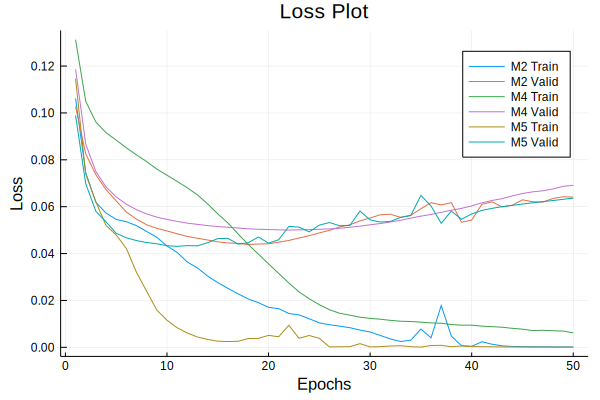

In [ ]:
plt_2 = plot([train_loss_m2, valid_loss_m2, train_loss_m4, valid_loss_m4, train_loss_m5, valid_loss_m5], 
              xlabel="Epochs", 
              ylabel="Loss", 
              title="Loss Plot", 
              label=["M2 Train" "M2 Valid" "M4 Train" "M4 Valid" "M5 Train" "M5 Valid"])

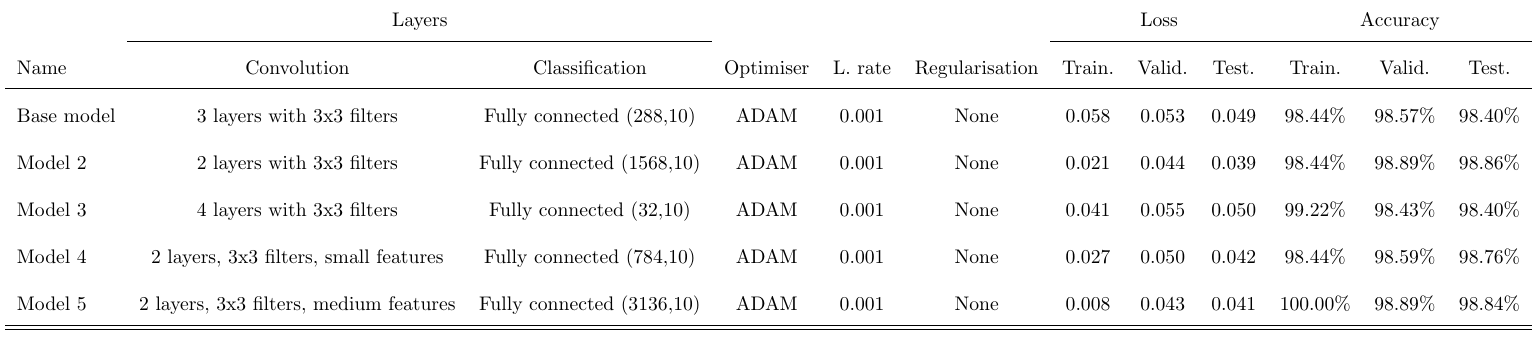

### Model 6

Additionally, we'll look to see if changing the filter sizes has any positive effect on the validation loss.

In [ ]:
model_6 = Chain(
        Conv((9, 9), 1=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((9, 9), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(256, 10),
        softmax,
    ) |> gpu

accuracy_6(x, y) = mean(onecold(model_6(x)) .== onecold(y))
loss_6(x, y)     = crossentropy(model_6(x), y)
optimiser      = ADAM(0.001)

nothing

In [ ]:
train_loss_m6 = []
valid_loss_m6 = []
best_model_6 = train(train_loss_m6, valid_loss_m6, loss_6, model_6, accuracy_6); 

Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.13192967	0.11050194	0.97656		0.96836
5	0.054691654	0.07137312	0.99219		0.97811
10	0.018552568	0.062760815	0.99219		0.98308
15	0.005356718	0.056408267	1.0		0.98687
20	0.0009892636	0.058499053	1.0		0.98667
25	0.0002361977	0.059542928	1.0		0.98647
30	0.0001464614	0.061909564	1.0		0.98587
35	0.00010214026	0.06440827	1.0		0.98567
40	6.447448e-5	0.06661266	1.0		0.98547
45	4.1011128e-5	0.06968642	1.0		0.98567
50	2.6351292e-5	0.072354116	1.0		0.98547


In [ ]:
println("")
println("Model 6: Larger filter sizes")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_6,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_6,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_6,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_6,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_6,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_6,testset...)*100,digits=2))%")


Model 6: Larger filter sizes
-------------------------------------------------------------
Lowest validation loss:				 0.052693017
Training loss at best validation epoch:		 0.0028368733
Testing loss at best valdation epoch:		 0.054780383

Accuracy at best validation epoch:		 98.67%
Training accuracy at best validation epoch:	 100.0%
Testing accuracy at best validation epoch:	 98.48%


Seems that model 5 is still the best model. We'll continue with the smaller filter sizes.

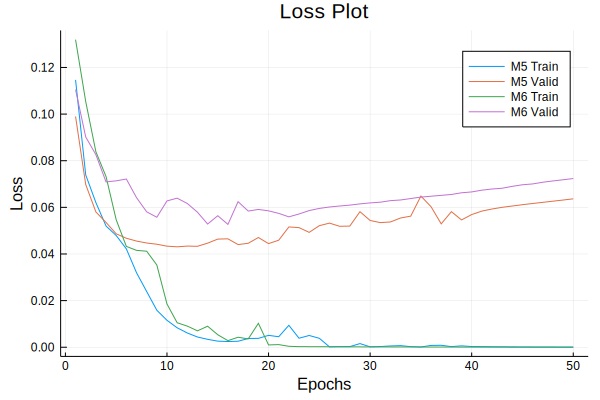

In [ ]:
plt_2 = plot([train_loss_m5, valid_loss_m5, train_loss_m6, valid_loss_m6], 
              xlabel="Epochs", 
              ylabel="Loss", 
              title="Loss Plot", 
              label=["M5 Train" "M5 Valid" "M6 Train" "M6 Valid"])

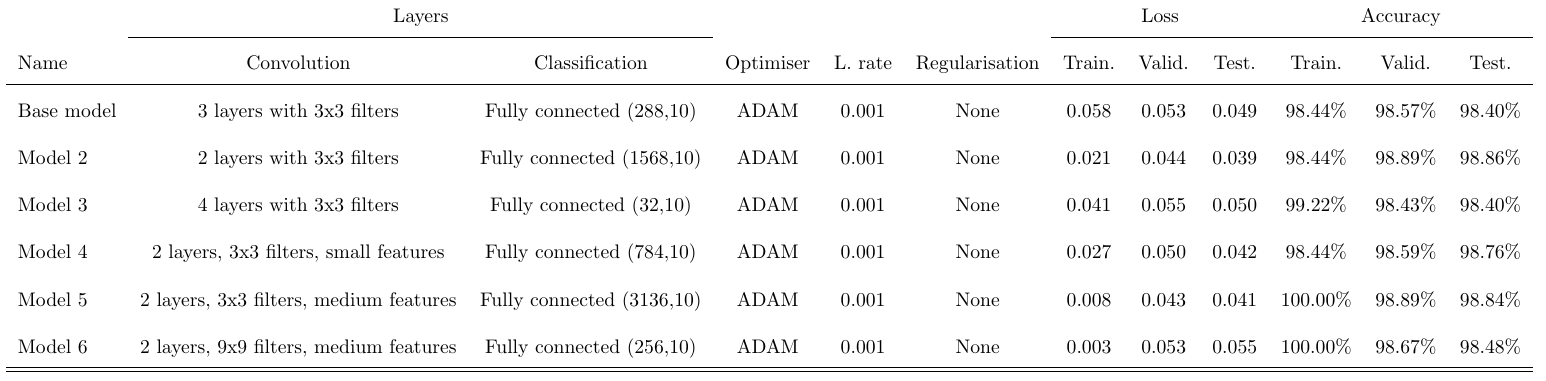

### Model 7 & 8

We'll next consider altering the classification layer of the CNN. We'll look at two possible model variants; both 2 layers but the first with (3136 => 128) and (128 => 10) nodes and the second with (3136 => 64) and (512 => 10) nodes. In preliminary testing of this model, I found a smaller learning rate of 0.0005 better demonstrates the improvements of these variants.

In [ ]:
model_7 = Chain(
        Conv((3, 3), 1=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(3136, 128),
        Dense(128,10),
        softmax,
    ) |> gpu

accuracy_7(x, y) = mean(onecold(model_7(x)) .== onecold(y))
loss_7(x, y)     = crossentropy(model_7(x), y)
optimiser      = ADAM(0.0005)

nothing

In [ ]:
model_8 = Chain(
        Conv((3, 3), 1=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(3136, 512),
        Dense(512,10),
        softmax,
    ) |> gpu

accuracy_8(x, y) = mean(onecold(model_8(x)) .== onecold(y))
loss_8(x, y)     = crossentropy(model_8(x), y)
optimiser      = ADAM(0.0005)

nothing

In [ ]:
train_loss_m7 = []
train_loss_m8 = []
valid_loss_m7 = []
valid_loss_m8 = []

println("Model 7: (3136 => 512) (512 => 10)")
best_model_7 = train(train_loss_m7, valid_loss_m7, loss_7, model_7, accuracy_7)

println("")
println("Model 8: (3136 => 128) => (128,10)")
best_model_8 = train(train_loss_m8, valid_loss_m8, loss_8, model_8, accuracy_8);

Model 7: (3136 => 512) (512 => 10)
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.0940331	0.0982795	0.96875		0.97274
5	0.022627123	0.045837536	0.98438		0.98627
10	0.0074223913	0.039053477	1.0		0.98886
15	0.0025525128	0.044509735	1.0		0.98886
20	0.049255192	0.06683084	0.99219		0.98488
25	0.0009289866	0.06352148	1.0		0.98587
30	4.5272634e-5	0.0456777	1.0		0.99045
35	3.8781312e-5	0.04985884	1.0		0.98965
40	2.8857861e-5	0.052852474	1.0		0.98985
45	1.9044854e-5	0.05567831	1.0		0.98985
50	1.1594278e-5	0.058603425	1.0		0.98965

Model 8: (3136 => 128) => (128,10)
Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.08580004	0.093779296	0.97656		0.97393
5	0.015232733	0.042171735	0.98438		0.98945
10	0.002936378	0.0506054	1.0		0.98846
15	0.0007091055	0.059096467	1.0		0.98886
20	0.00960673	0.05058893	1.0		0.99025
25	0.00011623055	0.072662964	1.0		0.987

In [ ]:
println("Model 7: (3136 => 512) (512 => 10)")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_7,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_7,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_7,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_7,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_7,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_7,testset...)*100,digits=2))%")


println("")
println("Model 8: (3136 => 128) => (128,10)")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_8,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_8,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_8,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_8,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_8,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_8,testset...)*100,digits=2))%")

Model 7: (3136 => 512) (512 => 10)
-------------------------------------------------------------
Lowest validation loss:				 0.037813134
Training loss at best validation epoch:		 0.0119189285
Testing loss at best valdation epoch:		 0.03628214

Accuracy at best validation epoch:		 98.91%
Training accuracy at best validation epoch:	 99.22%
Testing accuracy at best validation epoch:	 98.86%

Model 8: (3136 => 128) => (128,10)
-------------------------------------------------------------
Lowest validation loss:				 0.04172848
Training loss at best validation epoch:		 0.0077065704
Testing loss at best valdation epoch:		 0.03463008

Accuracy at best validation epoch:		 98.93%
Training accuracy at best validation epoch:	 100.0%
Testing accuracy at best validation epoch:	 98.94%


Below, again we have plots of cross-entropy loss on validation and testing sets of 2 new models trained compared to the rolling best model 5. Model 7 gives us a new best low value of 0.038, compared to 0.043 of model 5. We'll proceed with further model modifications using this model.

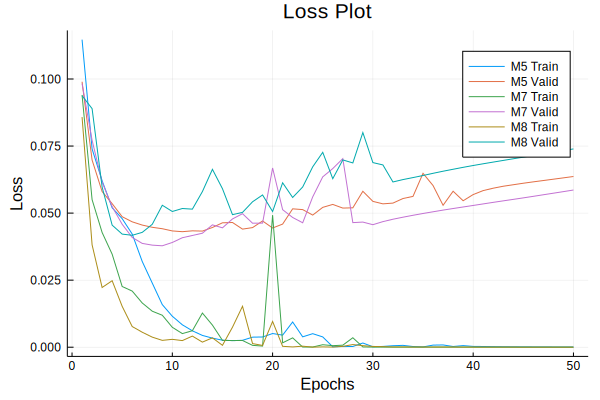

In [ ]:
plt_2 = plot([train_loss_m5, valid_loss_m5, train_loss_m7, valid_loss_m7, train_loss_m8, valid_loss_m8], 
              xlabel="Epochs", 
              ylabel="Loss", 
              title="Loss Plot", 
              label=["M5 Train" "M5 Valid" "M7 Train" "M7 Valid" "M8 Train" "M8 Valid"])

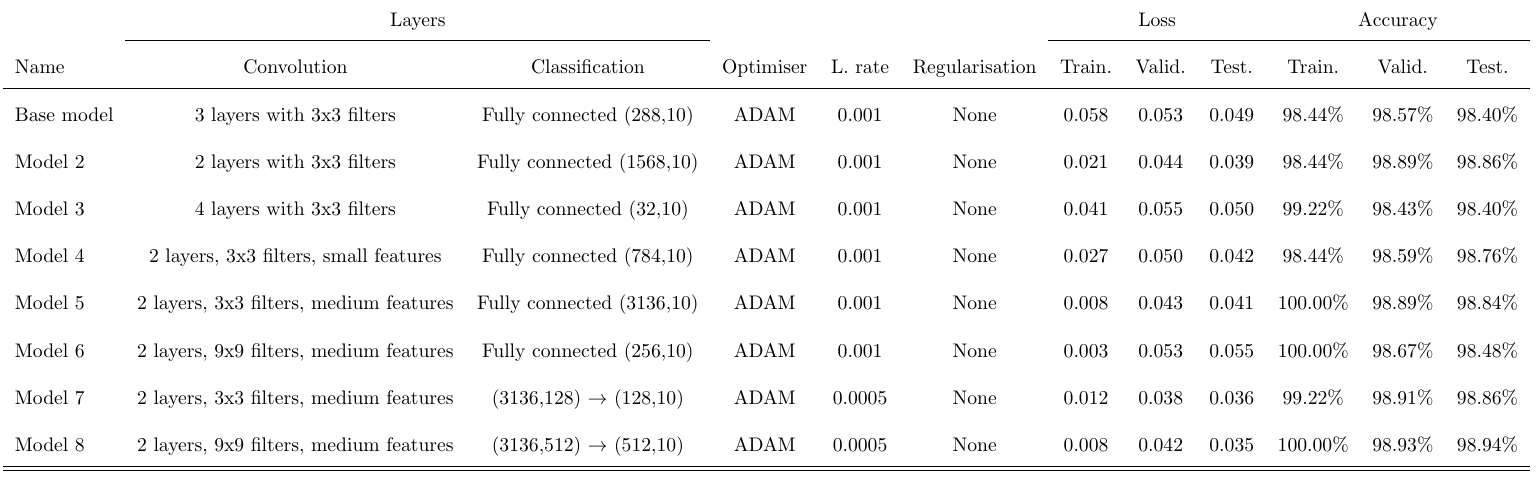

### Model 9

Next, we'll consider using batch normalisation (see https://arxiv.org/pdf/1502.03167.pdf) as a regularisation technique to combat model overfitting - and potentially give us a better validation loss value.

In [ ]:
model_9 = Chain(
        Conv((3, 3), 1=>32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32=>64, pad=(1, 1), relu),
        MaxPool((2, 2)),

        # Reshape magic, turn each 7x7 matrix into a vector.
        x -> reshape(x, :, size(x, 4)),
        Dense(3136, 128),
        BatchNorm(128, relu),
        Dense(128,10),
        BatchNorm(10, relu),
        softmax,
    ) |> gpu

accuracy_9(x, y) = mean(onecold(model_9(x)) .== onecold(y))
loss_9(x, y)     = crossentropy(model_9(x), y)
optimiser      = ADAM(0.001)

nothing

In [ ]:
train_loss_m9 = []
valid_loss_m9 = []
best_model_9 = train(train_loss_m9, valid_loss_m9, loss_9, model_9, accuracy_9); 

Epoch	Training loss	Valid loss	Training acc	Valid acc
-----------------------------------------------------------------
1	0.639552	0.6163872	0.98438		0.98547
5	0.18093249	0.18678358	0.98438		0.99284
10	0.058970567	0.08113907	1.0		0.99303
15	0.030368488	0.051393453	1.0		0.99284
20	0.014587004	0.03839744	1.0		0.99284
25	0.009126761	0.0313405	1.0		0.99383
30	0.0048172055	0.028779969	1.0		0.99303
35	0.0029935876	0.02791399	1.0		0.99284
40	0.002732261	0.02496936	1.0		0.99483
45	0.0012920671	0.02452478	1.0		0.99443
50	0.0007813056	0.025207093	1.0		0.99443


In [ ]:
println("Model 9: Including batch normalisation regulariser")
println("-------------------------------------------------------------")
println("Lowest validation loss:\t\t\t\t $(loss(best_model_9,validset...).data)")
println("Training loss at best validation epoch:\t\t $(loss(best_model_9,trainset[1]...).data)")
println("Testing loss at best valdation epoch:\t\t $(loss(best_model_9,testset...).data)")
println("")
println("Accuracy at best validation epoch:\t\t $(round(accuracy(best_model_9,validset...)*100,digits=2))%")
println("Training accuracy at best validation epoch:\t $(round(accuracy(best_model_9,trainset[1]...)*100,digits=2))%")
println("Testing accuracy at best validation epoch:\t $(round(accuracy(best_model_9,testset...)*100,digits=2))%")

Model 9: Including batch normalisation regulariser
-------------------------------------------------------------
Lowest validation loss:				 0.024368424
Training loss at best validation epoch:		 0.0016399155
Testing loss at best valdation epoch:		 0.027243244

Accuracy at best validation epoch:		 99.44%
Training accuracy at best validation epoch:	 100.0%
Testing accuracy at best validation epoch:	 99.18%


We can see that batch normalisation has greatly improved the the model across all metrics. We have a new best model loss of 0.024 compared to 0.038 of model 7. The improvement of this model in comparison to model 7 is stark in the plot of the cross-entropy loss, for the training and validation data sets.

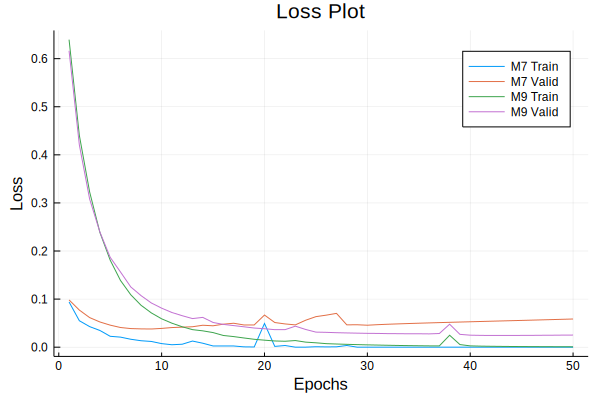

In [ ]:
plt_2 = plot([train_loss_m7, valid_loss_m7, train_loss_m9, valid_loss_m9], 
              xlabel="Epochs", 
              ylabel="Loss", 
              title="Loss Plot", 
              label=["M7 Train" "M7 Valid" "M9 Train" "M9 Valid"])

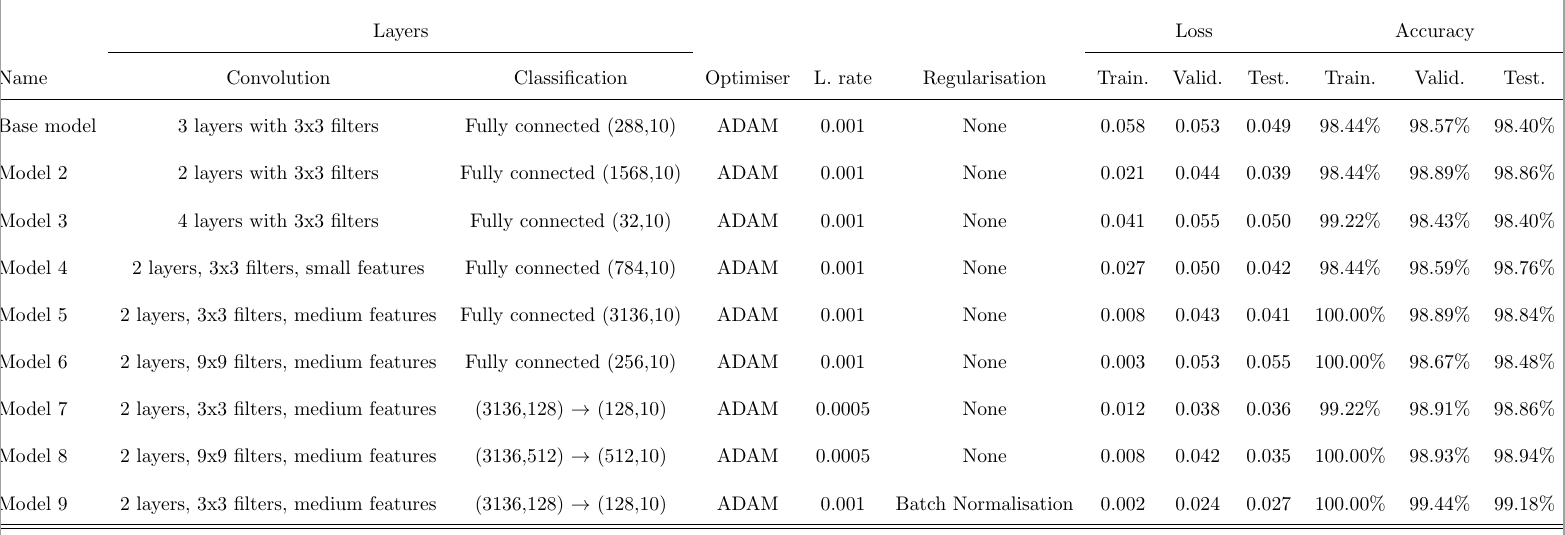

### Conclusion

Our final model had the most drastic increase in performance, once we added batch normalisation as a form of regularisation to tackle overfitting - which CNNs are notorious for. Our final model 9 had training, validation & testing accuracies all above 99% for the epoch of the lowest loss. The losses for each data set were also the lowest out of all model iterations.